In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
import mord

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc

### Load and Explore Data

In [2]:
df = pd.read_csv('winequality-red.csv', delimiter=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.quality.value_counts(sort=False).sort_index()

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [131]:
# Relabel
# df.quality = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int')
df.quality = df.quality.map(lambda x: x-3)

In [132]:
df.quality.value_counts()

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

In [133]:
corr = df.corr()

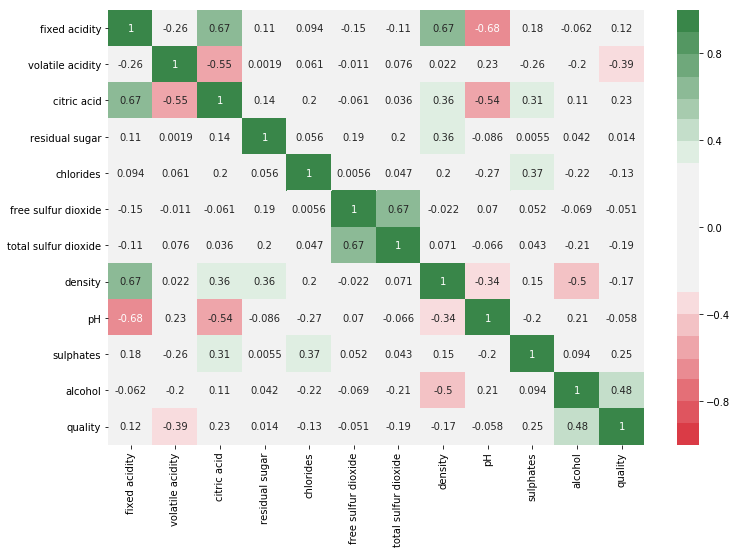

In [134]:
plt.figure(num=None, figsize=(12, 8))
sns.heatmap(corr, center=0, vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 133, sep=80, n=20), annot=True)

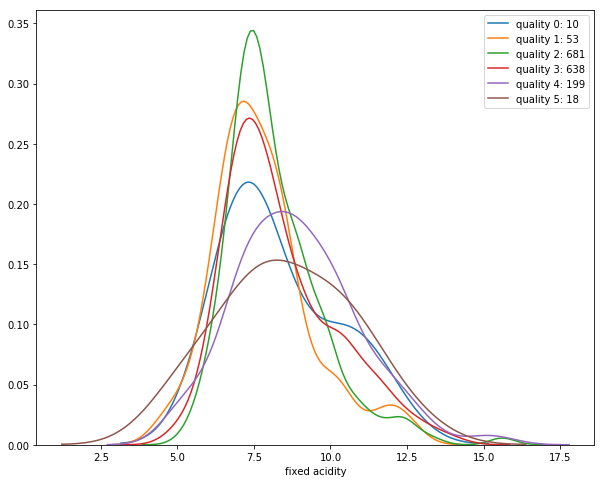

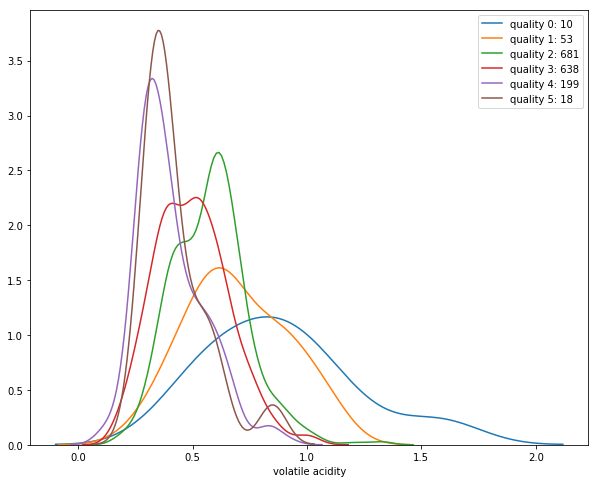

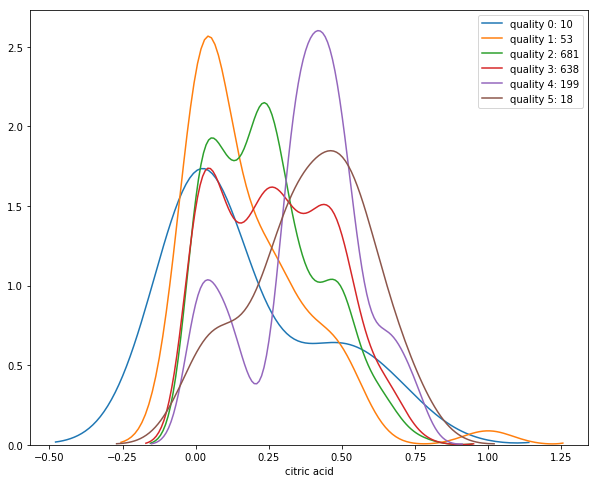

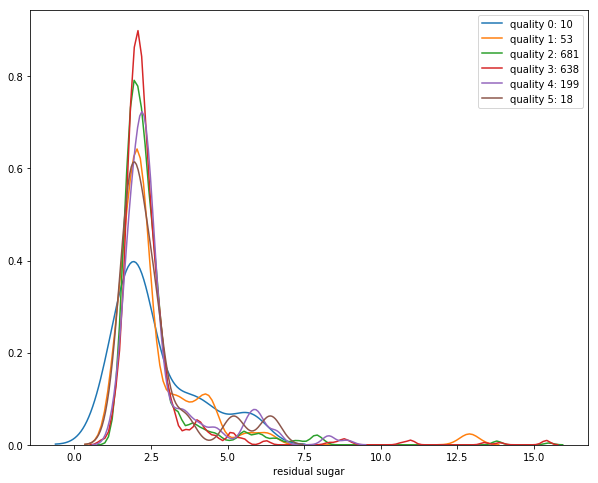

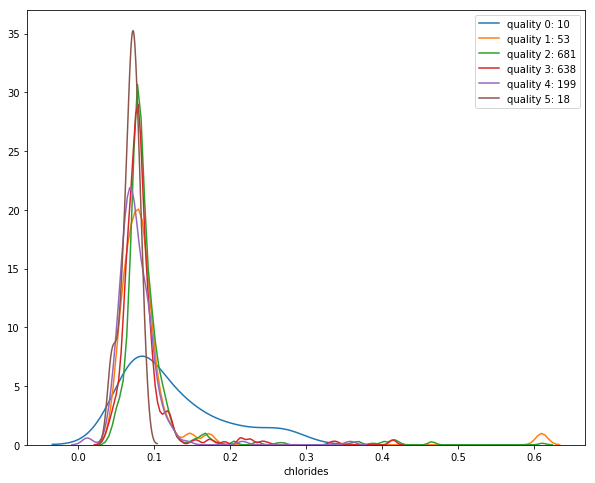

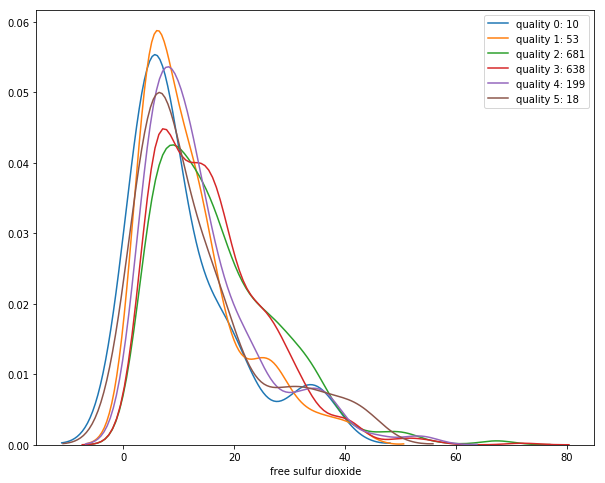

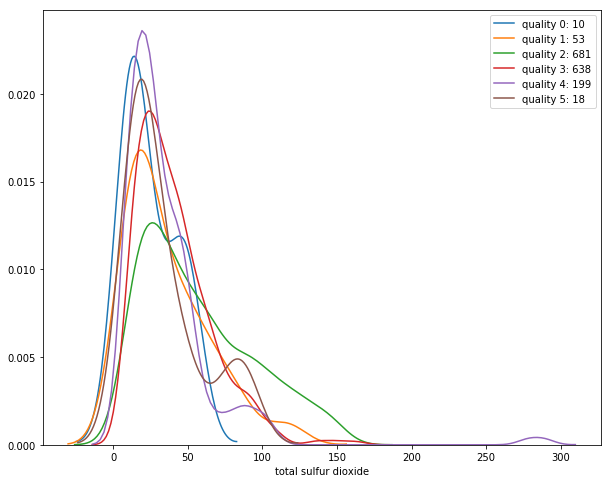

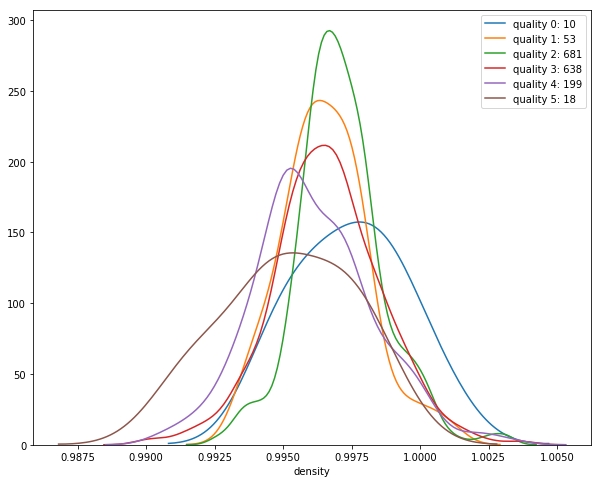

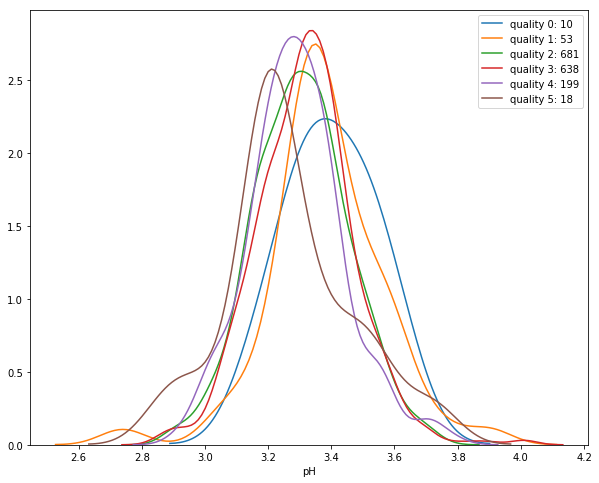

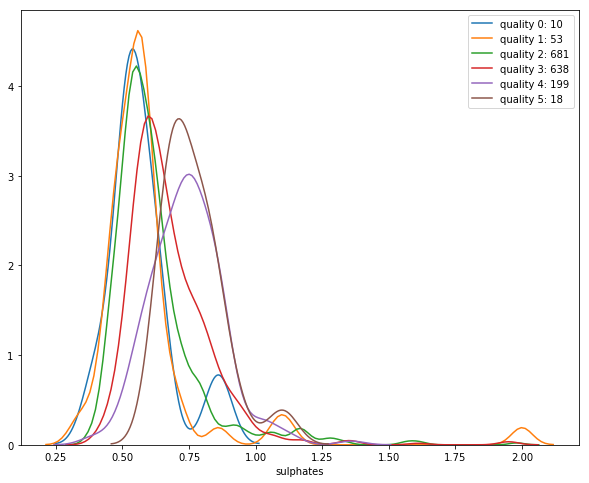

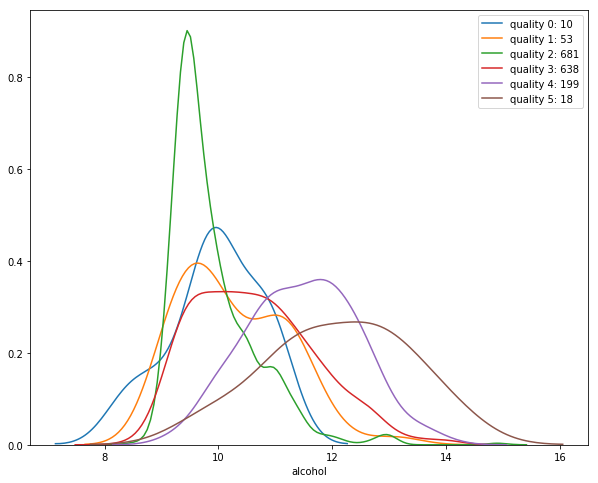

In [135]:
for f in df.columns[:-1]:
    plt.figure(num=None, figsize=(10, 8))
    for q in sorted(df.quality.unique()):
        sns.distplot(df[f][df.quality == q], hist=False, label=('quality %d: %d' % (q, df[f][df.quality == q].count())))
    plt.legend()

/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/cneiderer/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


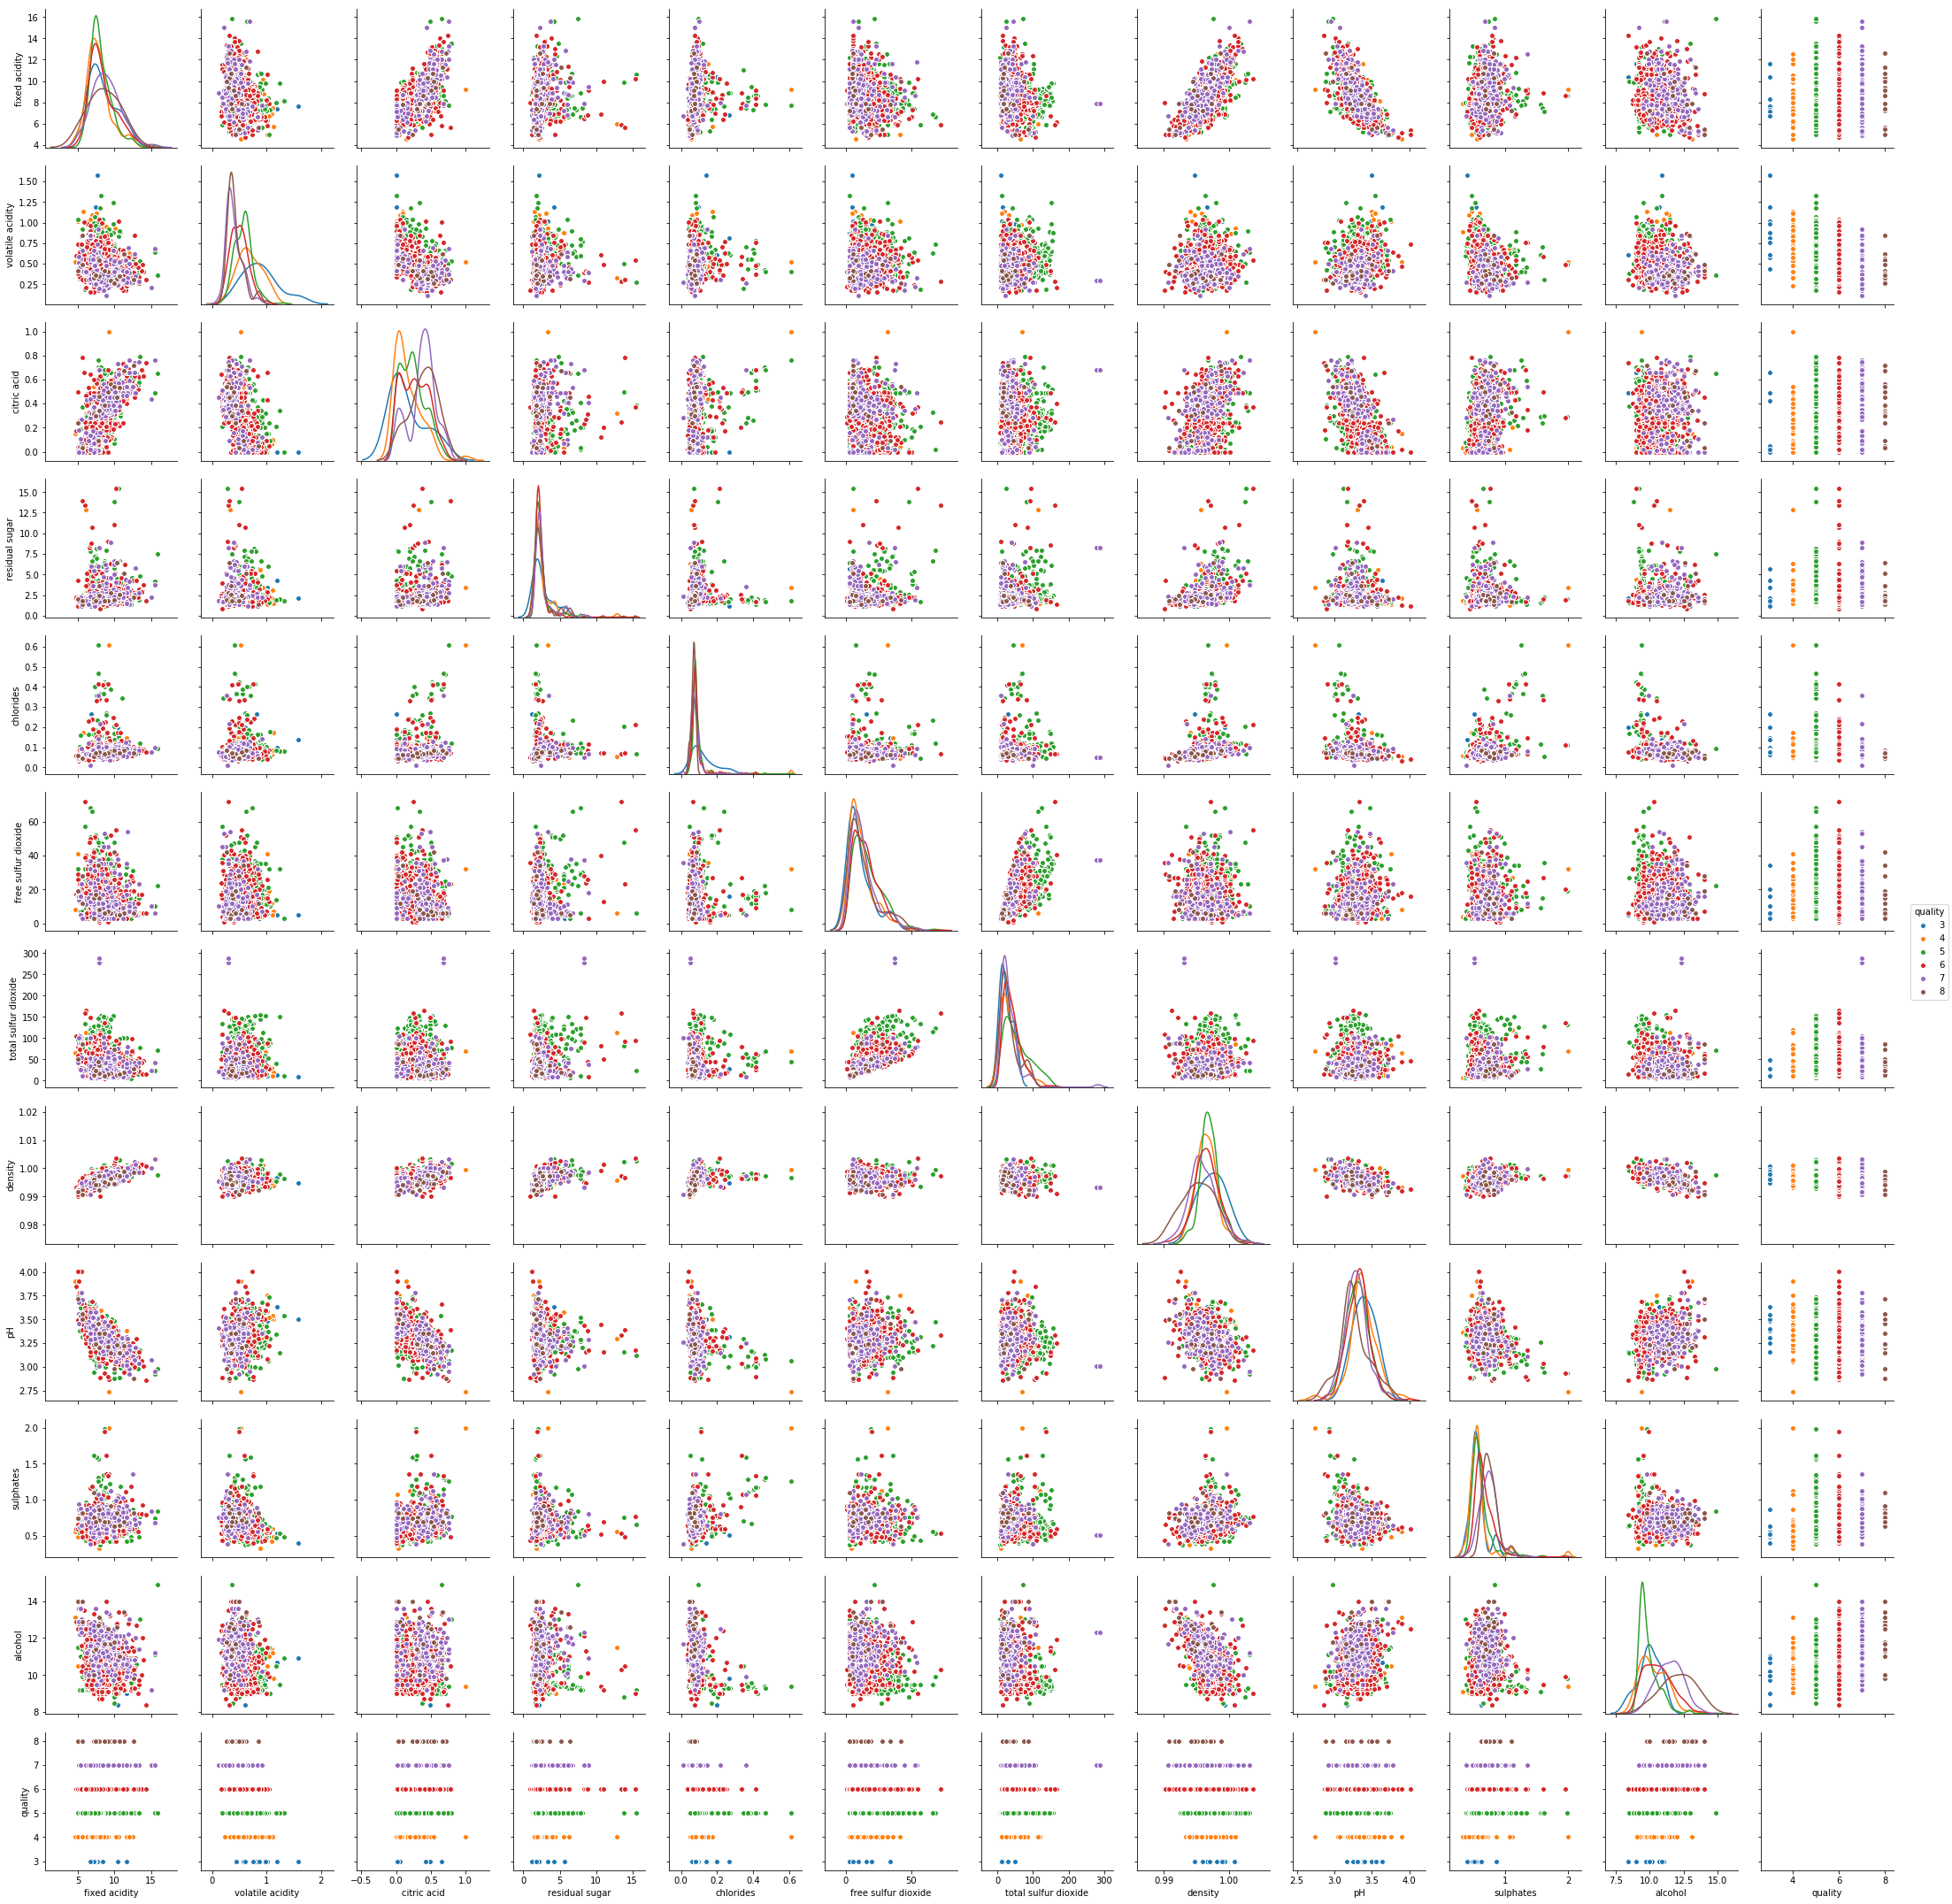

In [8]:
sns.pairplot(df, hue='quality', diag_kind='kde')

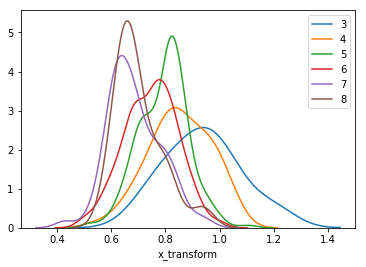

In [9]:
tmp = pd.concat([df['volatile acidity'], df['volatile acidity'].apply(lambda x: x ** (2/5)), df['quality']], 
                axis=1, keys=['x', 'x_transform', 'q'])
for q in sorted(tmp.q.unique()):
    sns.distplot(tmp.x_transform[tmp.q==q], hist=False, label=q)

### Subset Data

In [136]:
df_subset = df.copy()
df_subset['quality2'] = pd.cut(df.quality, bins=3, labels=[1, 2, 3]).astype('int') #['good', 'medium', 'bad'])

In [137]:
df_subset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2,2


### Split Data 

In [138]:
# Split 
# y = resampled_df.quality
# X = resampled_df.drop(columns='quality')

# y = df_subset.quality2
# X = df_subset.drop(columns=['quality', 'quality2'])

y = df.quality
X = df.drop(columns='quality')

# X = df[['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'alcohol']]
# X = df[['volatile acidity', 'alcohol']]

# Make sure intercept exists
if ~any(X.columns == 'Intercept'):
    X.insert(0, 'Intercept', 1)
else: 
    X.Intercept = 1
    
# Stratified Split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, stratify=y, test_size=.7, random_state=129)

### Build Models

#### Vanilla Logistic w/out Balanced Class Weight

In [139]:
# lr1 = make_pipeline(PolynomialFeatures(degree=2, interaction_only=False), LogisticRegression(C=1e3, random_state=129))
lr1 = LogisticRegression(C=1e3, random_state=129)
lr1.fit(X_train, y_train)

print(lr1)
# make predictions
lr1_pred = lr1.predict(X_test)
# summarize the fit of the model
print(classification_report(y_test, lr1_pred))
print(confusion_matrix(y_test, lr1_pred))

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.25      0.14      0.18         7
          1       0.00      0.00      0.00        37
          2       0.64      0.75      0.69       477
          3       0.51      0.62      0.56       447
          4       0.33      0.03      0.05       139
          5       0.00      0.00      0.00        13

avg / total       0.52      0.57      0.53      1120

[[  1   0   6   0   0   0]
 [  1   0  21  14   0   1]
 [  2   0 359 114   2   0]
 [  0   1 163 275   5   3]
 [  0   0   9 124   4   2]
 [  0   0   1  11   1   0]]


#### Balanced Logistic

In [140]:
# lr2 = make_pipeline(PolynomialFeatures(degree=2, interaction_only=False), LogisticRegression(C=1e3, class_weight='balanced', random_state=129))
lr2 = LogisticRegression(C=1e3, class_weight='balanced', random_state=129)
lr2.fit(X_train, y_train)

print(lr2)

# make predictions
lr2_pred = lr2.predict(X_test)

# summarize the fit of the model
print(classification_report(y_test, lr2_pred))
print(confusion_matrix(y_test, lr2_pred))

LogisticRegression(C=1000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.08      0.14      0.10         7
          1       0.19      0.35      0.25        37
          2       0.66      0.69      0.67       477
          3       0.53      0.45      0.49       447
          4       0.43      0.36      0.39       139
          5       0.09      0.31      0.14        13

avg / total       0.55      0.53      0.54      1120

[[  1   2   4   0   0   0]
 [  1  13  12   9   0   2]
 [  4  35 329  99   6   4]
 [  7  17 146 200  57  20]
 [  0   2   9  62  50  16]
 [  0   0   0   6   3   4]]


### Plot ROC Curves

In [141]:
from sklearn.preprocessing import LabelBinarizer

In [166]:
# Binarize the output
classes = sorted(y.unique())
print(classes)
# y2 = label_binarize(y, classes=classes)
lb = LabelBinarizer()
y2 = lb.fit_transform(y)
n_classes = y2.shape[1]
# Resplit using same seed
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=.7, random_state=129)

[0, 1, 2, 3, 4, 5]


In [354]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=1000, class_weight='balanced', random_state=129))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_pred = classifier.predict(X_test)

print(classifier)
# print(classification_report(y_test, y_pred))
print(classification_report(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))
print(confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred)))

OneVsRestClassifier(estimator=LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=129,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=1)
             precision    recall  f1-score   support

          0       0.03      0.25      0.06         8
          1       0.07      0.40      0.12        43
          2       0.62      0.46      0.53       489
          3       0.55      0.50      0.52       443
          4       0.30      0.10      0.15       127
          5       0.00      0.00      0.00        10

avg / total       0.52      0.43      0.46      1120

[[  2   4   2   0   0   0]
 [  5  17  15   6   0   0]
 [ 21 161 226  70  11   0]
 [ 34  60 111 220  18   0]
 [  1   3  12  97  13   1]
 [  0   0   0   9   1   0]]


In [355]:
cr = classification_report(y_test, y_pred)

In [356]:
import matplotlib.pyplot as plt
import numpy as np

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdYlGn'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
    

[0.09, 0.25, 0.13]
[0.07, 0.44, 0.12]
[0.64, 0.74, 0.68]
[0.52, 0.61, 0.56]
[0.3, 0.75, 0.43]
[0.05, 0.7, 0.1]
plotMat: [[0.09, 0.25, 0.13], [0.07, 0.44, 0.12], [0.64, 0.74, 0.68], [0.52, 0.61, 0.56], [0.3, 0.75, 0.43], [0.05, 0.7, 0.1]]
support: [8, 43, 489, 443, 127, 10]


AttributeError: 'PolyCollection' object has no attribute 'get_axes'

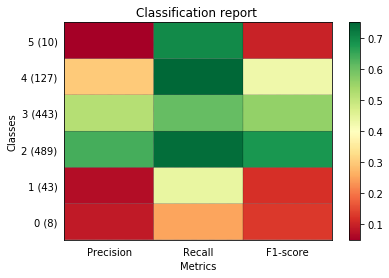

In [353]:
plot_classification_report(cr)
# plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
# plt.close()

In [273]:
X, Y = np.meshgrid(np.arange(0, 6, 1), np.arange(5, -1, -1))
Z = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
norm_Z = normalize(Z, axis=1)
# norm_Z = (Z - Z.min()) / (Z.max() - Z.min())

Text(0.5,1,'Red Wine Quality\n\n')

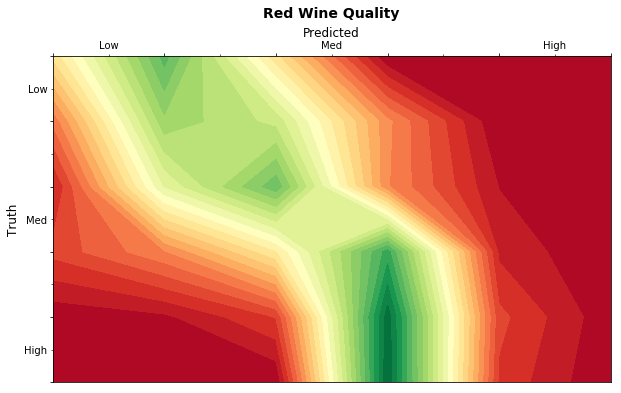

In [335]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.contourf(X, Y, norm_Z, 25, cmap='RdYlGn', vmin=0, vmax=1)
# ax2 = plt.colorbar();

ax.xaxis.set_ticks_position('top') 
ax.xaxis.set_label_position('top')

ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_xticklabels(['Low', '', 'Med', '', 'High'], minor=True)
ax.set_xticklabels([], minor=False)

ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5], minor=True)
ax.set_yticklabels(['High', '', 'Med', '', 'Low'], minor=True)
ax.set_yticklabels([], minor=False)

ax.set_xlabel('Predicted', fontdict={'size': 12})
ax.set_ylabel('Truth', fontdict={'size': 12})
ax.set_title('Red Wine Quality\n\n', fontdict={'size': 14, 'weight': 'bold'})

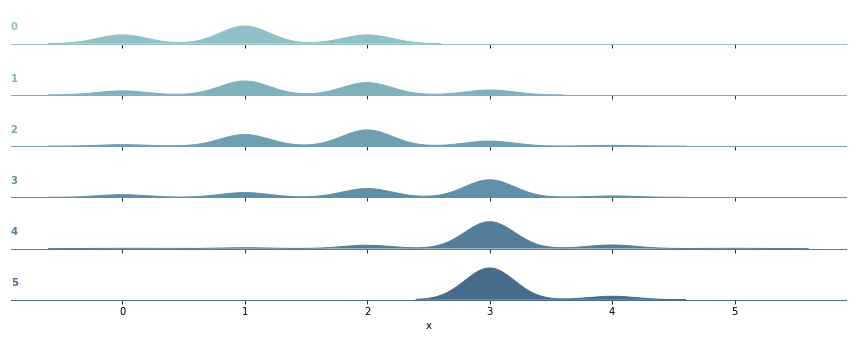

In [337]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=lb.inverse_transform(y_pred), g=lb.inverse_transform(y_test)))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=0.8, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1, bw=.2)
# g.map(sns.distplot, "x", kde=False, norm_hist=True)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=1, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.tight_layout()

In [216]:
# from sklearn.preprocessing import normalize
# import scipy

In [276]:
# f = scipy.interpolate.interp2d(X, Y, Z, kind='linear')
# X1 = np.linspace(0, 5, 50)
# Y1 = np.linspace(0, 5, 50)
# Z1 = f(X1, Y1)

In [278]:
# fig, ax = plt.subplots(figsize=(10, 6))
# plt.contourf(X1, Y1, Z1, 20, cmap='RdGy')
# plt.colorbar();

# ax.set_xlabel('Predicted', fontdict={'size': 12})
# ax.set_ylabel('Truth', fontdict={'size': 12})
# ax.set_title('Wine Quality Prediction', fontdict={'size': 12, 'weight': 'bold'})

In [168]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

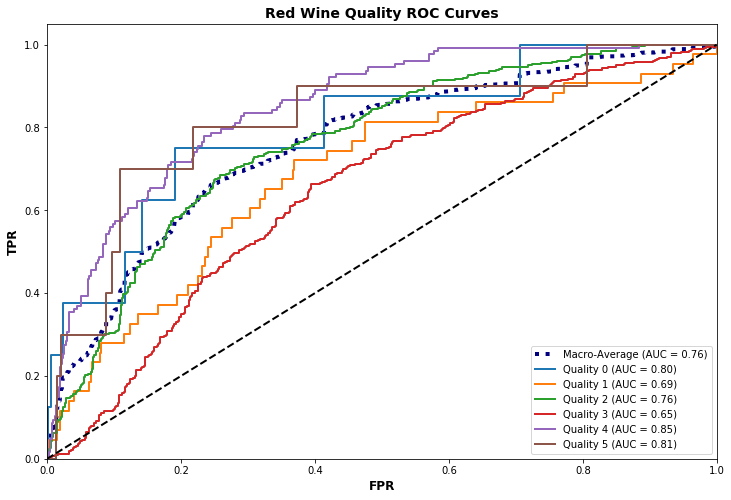

In [338]:
# Compute macro-average ROC curve and ROC area
fig, ax = plt.subplots(figsize=(12, 8))

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-Average (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
   
# for i in range(n_classes):
for i in sorted(classes):    
    plt.plot(fpr[i], tpr[i], lw=2, label='Quality {0} (AUC = {1:0.2f})' ''.format(classes[i], roc_auc[i]))    


ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('FPR', fontdict={'size': 12, 'weight': 'bold'})
ax.set_ylabel('TPR', fontdict={'size': 12, 'weight': 'bold'})
ax.set_title('Red Wine Quality ROC Curves', fontdict={'size': 14, 'weight': 'bold'})
ax.legend(loc="lower right")

In [147]:
l = [.8, .69, .76, .65, .85, .81]

In [152]:
# simple mean
np.sum(l) / len(l)

0.76000000000000012

In [150]:
# harmonic mean
len(l) / np.sum([1/x for x in l])

0.75333682410818259

In [151]:
# geometric mean
np.prod(l) ** (1/len(l))

0.75670800547146144